In [ ]:
!pip install torch

### RL Algo

State
deferable_demand * 3
flywheel_amt
1. demand(inst): float
2. sun: int (percentage)
2. buy_price: int (cents/joule)
3. sell_price: int (cents/joule)
5. stacked, use last X values

Action
1. import_export_amount (in joules): positive for import and negative for export
2. release_store_amount (in joules): positive for release and negative for store
3. for each deferrable demand: energy to allocate for that time tick as a float

In [ ]:
from copy import deepcopy
from models import Day, Tick
from utils import get_db
from pydantic import BaseModel

db = get_db()

days = db.days.find().limit(1000).sort("day", 1)
days = [Day.model_validate(day) for day in days]
id2day = {day.day: day for day in days}

ticks = db.ticks.find().limit(60000)
ticks = [Tick.model_validate(tick) for tick in ticks]

day2ticks = {}
for id, tick in enumerate(ticks):
    if tick.day not in day2ticks:
        day2ticks[tick.day] = []
    
    day2ticks[tick.day].append(tick)

print("Num days: ", len(days))
print("Num ticks: ", len(ticks))

['/Users/johnyeocx/miniconda3/envs/smartgrid/lib/python39.zip', '/Users/johnyeocx/miniconda3/envs/smartgrid/lib/python3.9', '/Users/johnyeocx/miniconda3/envs/smartgrid/lib/python3.9/lib-dynload', '', '/Users/johnyeocx/miniconda3/envs/smartgrid/lib/python3.9/site-packages']


/var/folders/r9/_55t9mn521x1d3251hfynrpm0000gn/T/ipykernel_69151/601081121.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns)


Iteration 100
Cost: 8049.48
EMA (100):  8512.458409399365
Time taken: 32.01s
--------------------

Iteration 200
Cost: 7886.137
EMA (100):  7774.914533643329
Time taken: 63.5s
--------------------

Iteration 300
Cost: 1312.943
EMA (100):  4315.5409194294225
Time taken: 96.21s
--------------------

Iteration 400
Cost: 4194.252
EMA (100):  1899.5316995810672
Time taken: 127.91s
--------------------

Iteration 500
Cost: 6879.014
EMA (100):  2183.1962999056846
Time taken: 159.65s
--------------------

Iteration 600
Cost: 6010.058
EMA (100):  1555.2987865291263
Time taken: 191.14s
--------------------

Iteration 700
Cost: 1895.95
EMA (100):  1696.712026106354
Time taken: 222.69s
--------------------

Iteration 800
Cost: 201.282
EMA (100):  1770.5795468713716
Time taken: 253.95s
--------------------

Iteration 900
Cost: 1007.643
EMA (100):  2918.849189343048
Time taken: 286.05s
--------------------

Iteration 1000
Cost: 1185.225
EMA (100):  3116.327177654842
Time taken: 317.76s
-------------

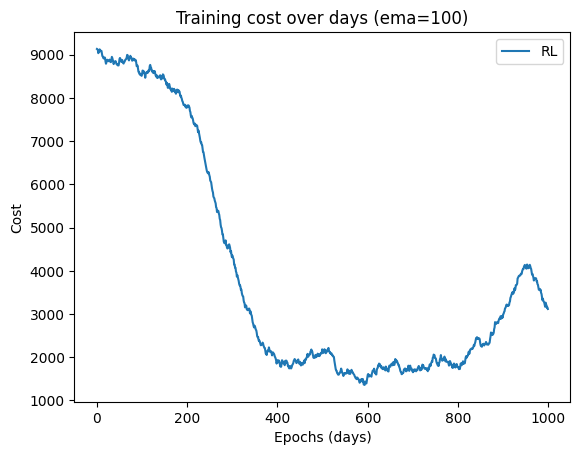

In [13]:
import sys
import os
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.insert(0, parent_directory)

import time

import numpy as np
from gen_data import getTicksForDay
from policy import PolicyNetwork, ValueNetwork
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
from utils import  get_ema, print_release_store
from copy import deepcopy


MAX_DEFERABLES = 3
MPP = 4
TICK_LENGTH = 300 / 60
GAMMA = 0.99
STACKED_NUM = 10
MAX_FLYWHEEL_CAPACITY = 50
MAX_IMPORT_EXPORT = 100

STATE_SIZE = MAX_DEFERABLES * 3 + 1 + 5 + STACKED_NUM * 3 # 1 for flywheel_amt, 5 for cur tick info, 3 for each past tick
ACTION_SIZE = 1 + 1 + MAX_DEFERABLES # 1 for buy/sell, 1 for store/release, 1 for each deferable

# Penalties
EXCEED_FLYWHEEL_PENALTY = 0
NEGATIVE_ALLOCATION_PENALTY = 0
OVER_ALLOCATION_PENALTY = 0
NEGATIVE_ENERGY_PENALTY = 0
DEFERABLE_DEADLINE_PENALTY = 20


def simulate_day_naive(day, ticks, use_flywheel=False, export_extra=False):
    costs = []
    flywheel_amt = 0
    for tick in ticks:
        power = (tick.sun / 100) * MPP 
        sun_energy = power * TICK_LENGTH # sun in percentage to joules per tick
        
        total_energy = sun_energy

        if use_flywheel:
            total_energy += flywheel_amt
            flywheel_amt = 0

        total_energy -= tick.demand

        for deferable in day.deferables:
            if deferable.start == tick.tick:
                total_energy -= deferable.energy
        
        if total_energy < 0:
            cost = -total_energy * tick.sell_price
        elif use_flywheel:
            flywheel_amt = min(MAX_FLYWHEEL_CAPACITY, flywheel_amt + total_energy)
        elif export_extra: 
            cost = total_energy * tick.buy_price # Export extra energy
        
        costs.append(cost)
    
    return sum(costs)

def tick_to_vect(tick):
    return [tick.sun, tick.buy_price, tick.sell_price]

def tick_to_history(i, ticks, yest_ticks, STACKED_NUM):
    tick: Tick = ticks[i]
    cur = [tick.tick, tick.demand, tick.sun, tick.buy_price, tick.sell_price]
    for j in range(1, STACKED_NUM + 1):
        if i - j < 0 and abs(i - j) <= len(yest_ticks):
            prev = yest_ticks[i - j]
            cur.extend(tick_to_vect(prev))
            # cur.extend([0, 0, 0])
        elif i - j >= 0:
            prev = ticks[i - j]
            cur.extend(tick_to_vect(prev))
        else:
            cur.extend([0, 0, 0])

    return cur

# PENALTIES IN ACTION: Flywheel store/release invalid, Negative/over allocation

def get_sun_energy(tick, MPP):
    return (tick.sun / 100) * MPP * TICK_LENGTH

def update_deferable_demands(day_state, action, tick):
    deferables = day_state["deferables"]
    energy_spent = 0
    penalty = 0
    for i in range(len(deferables)):
        d = deferables[i]
        if d.start > tick.tick:
            continue
        
        allocation = action[i + 2].item()
        # print(f"D{i}:", round(d.energy, 3), "A:", round(allocation, 3))
        if d.end == tick.tick and d.energy > 0:
            energy_spent += d.energy
            d.energy = 0
            if d.energy > 10:
                penalty += d.energy * DEFERABLE_DEADLINE_PENALTY
        
        elif allocation < 0:
            penalty += -allocation * NEGATIVE_ALLOCATION_PENALTY
            continue
        elif allocation > d.energy:
            energy_spent += d.energy
            penalty += (allocation - d.energy) * OVER_ALLOCATION_PENALTY
        else:
            energy_spent += allocation
            d.energy -= allocation

    return energy_spent, penalty

def buy_sell_to_cost(imp_exp_amt, tick):
    if imp_exp_amt < 0:
        return imp_exp_amt * tick.buy_price
    else:
        return imp_exp_amt * tick.sell_price

def update_flywheel_amt(day_state, release_store_amt):
    cur_flywheel_amt = day_state["flywheel_amt"]
    penalty = 0

    # If release amount > flywheel amount, set release amount to flywheel amount and penalise
    if release_store_amt > cur_flywheel_amt:
        penalty += (release_store_amt - cur_flywheel_amt) * EXCEED_FLYWHEEL_PENALTY
        release_store_amt = cur_flywheel_amt
        
    # Else if store amount + cur_flywheel_amt > capacity, set release_store_amt to capacity - cur_flywheel_amt and penalise
    elif release_store_amt < 0 and -release_store_amt + cur_flywheel_amt > MAX_FLYWHEEL_CAPACITY:
        penalty += (-release_store_amt + cur_flywheel_amt - MAX_FLYWHEEL_CAPACITY) * EXCEED_FLYWHEEL_PENALTY
        release_store_amt = MAX_FLYWHEEL_CAPACITY - cur_flywheel_amt
    
    # If release_store > 0, draw energy and subtract from flywheel_amt
    day_state["flywheel_amt"] -= release_store_amt
    
    return release_store_amt, penalty

def environment_step(action, tick, day_state, print_info=False):
    total_penalty = 0
    
    # 1. Get total sun energy
    sun_energy = get_sun_energy(tick, MPP)
    total_energy = sun_energy

    # 2. Get energy bought/sold
    imp_exp_amt = action[0].item()
    total_energy += imp_exp_amt

    # 3. Get energy stored/released
    release_store_amt = action[1].item()
    release_store_amt, penalty = update_flywheel_amt(day_state, release_store_amt)
    total_penalty += penalty
    total_energy += release_store_amt

    # 4. Satisfy instantaneous demand
    total_energy -= tick.demand

    # 5. Satisfy deferable demands
    energy_spent, penalty = update_deferable_demands(day_state, action, tick)
    total_penalty += penalty
    total_energy -= energy_spent

    # 6. Buy more energy if total energy < 0
    if total_energy < 0:
        imp_exp_amt += -total_energy
    
    # todo: Limit max import / export amount
    if imp_exp_amt > MAX_IMPORT_EXPORT:
        imp_exp_amt = MAX_IMPORT_EXPORT
    elif imp_exp_amt < -MAX_IMPORT_EXPORT:
        imp_exp_amt = -MAX_IMPORT_EXPORT

    
    
    # TODO: Save rest of energy in flywheel 
    if total_energy > 0:
        if total_energy > MAX_FLYWHEEL_CAPACITY - day_state["flywheel_amt"]:
            energy_to_sell = total_energy - (MAX_FLYWHEEL_CAPACITY - day_state["flywheel_amt"])
            imp_exp_amt -= energy_to_sell

        day_state["flywheel_amt"] = min(MAX_FLYWHEEL_CAPACITY, day_state["flywheel_amt"] + total_energy)
        # TODO sell energy if flywheel is full

    cost = buy_sell_to_cost(imp_exp_amt, tick)

    if print_info:
        print("Tick: ", tick.tick)
        print("Sun E: ", round(sun_energy, 3))
        print("Imp/Exp: ", round(imp_exp_amt, 3))
        print("Cost: ", round(cost, 5))
        print("Rel/Sto: ", round(release_store_amt, 3))
        print("Ins D: ", round(tick.demand, 3))
        print("Def D: ", round(energy_spent, 3))
        print("E left: ", round(total_energy, 3))
        print("Penalty: ", round(total_penalty, 3))
        print('-' * 20)
        print()

    return cost, total_penalty

def run_simulation(ticks, yest_ticks, day, print_info=False):

    day_state = {
        "deferables": deepcopy(day.deferables),
        "flywheel_amt": 0
    }

    # print("Deferables: ", [[d.start, d.end] for d in day_state["deferables"]])

    log_probs = []
    rewards = []
    states = []
    costs = []
    penalties = []
    
    for i, tick in enumerate(ticks):
        state = []

        # Add deferable demand info
        deferables = day_state["deferables"]
        for j in range(len(deferables)):
            d = deferables[j]
            state.extend([d.energy, d.start, d.end])
        
        # Add store/release info
        state.append(day_state["flywheel_amt"])

        # Add history
        state.extend(tick_to_history(i, ticks, yest_ticks, STACKED_NUM))

        # Run policy network
        action, log_prob = policy_network.get_action(torch.tensor(state))
        log_probs.append(log_prob)

        # Environment step
        cost, penalty = environment_step(action, tick, day_state, print_info=print_info)
        # total_penalty += penalty
        penalties.append(penalty)
        costs.append(cost)
        rewards.append(-(cost + penalty))
        states.append(state)


    return log_probs, rewards, costs, penalties, states

def compute_returns(rewards, gamma=0.99):
    rewards = torch.tensor(rewards, dtype=torch.float32)
    rewards = rewards - rewards.mean()

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)

    returns = torch.tensor(returns, dtype=torch.float32)
    mean = returns.mean()
    std = returns.std()

    returns = (returns - mean) / (std + 1e-8)  # Normalize returns

    return returns

def compute_loss(log_probs, returns):
    returns = torch.tensor(returns)
    loss = 0
    for log_prob, G in zip(log_probs, returns):
        loss += -log_prob * G
    return loss

def predict(day, ticks, yest_ticks):
    log_probs, rewards, costs, penalties, states = run_simulation(ticks, yest_ticks, day)
    loss = compute_loss(log_probs, compute_returns(rewards))

    return {
        "reward": sum(rewards),
        "cost": sum(costs),
        "penalty": sum(penalties),
        "loss": loss
    }

RUNS_PER_TRAJECTORY = 10
def simulate_day(day, ticks, yest_ticks, filename, print_info=False):
    global max_returns
    
    # Run simulation
    total_loss = 0
    trajectories = []
    for i in range(RUNS_PER_TRAJECTORY):
        log_probs, rewards, costs, penalties, states = run_simulation(ticks, yest_ticks, day, print_info=print_info)
        trajectories.append((sum(rewards), sum(costs), sum(penalties)))
        returns = compute_returns(rewards)
        total_loss += compute_loss(log_probs, returns)

    # Taking only return of first tick 
        

    average_loss = total_loss / RUNS_PER_TRAJECTORY
    policy_network.optimizer.zero_grad()
    average_loss.backward()
    policy_network.optimizer.step()

    return {
        "loss": average_loss.item(),
        "reward": sum([r[0] for r in trajectories]) / len(trajectories),
        "cost": sum([r[1] for r in trajectories]) / len(trajectories),
        "penalty": sum([r[2] for r in trajectories]) / len(trajectories)
    }

results = []
policy_network = PolicyNetwork(STATE_SIZE, ACTION_SIZE)
day, yest_ticks = getTicksForDay(0)
naive_costs = []
naive_with_flywheel = []
naive_export_extra = []
results = []


start = 1
num_epochs = 1000
filename = f"checkpoints/pn_epochs{num_epochs}_trajruns_{RUNS_PER_TRAJECTORY}_ema100.pth"
start_time = time.time()
min_cost = 1e6
last_checkpoint = None
min_index = 0
for i in range(start, start + num_epochs):
    day, ticks = getTicksForDay(i)
    naive_costs.append(simulate_day_naive(day, ticks))
    naive_with_flywheel.append(simulate_day_naive(day, ticks, use_flywheel=True))
    naive_export_extra.append(simulate_day_naive(day, ticks, export_extra=True))

    last_checkpoint = {
        "mean_net": policy_network.mean_net.state_dict().copy(),
        "logstd": policy_network.logstd.clone()
    }

    r = simulate_day(day, ticks, yest_ticks, print_info=False, filename=filename)
    results.append(r)
    emas = get_ema([r["cost"] for r in results], 100)
    yest_ticks = ticks

    if last_checkpoint != None and emas[-1] < min_cost:
        min_index = i
        torch.save(last_checkpoint, filename)
        

    if i % 100 == 0:
        cur_time = time.time()
        print(f"Iteration {i}")
        # print("Reward", round(r["reward"], 3))
        print("Pen:", round(r["penalty"], 3))
        print("Cost:", round(r["cost"], 3))
        print("EMA (100): ", emas[-1])
        print(f"Time taken: {round(cur_time - start_time, 2)}s")
        print('-' * 20)
        print()

    yest_ticks = ticks


costs = [r["cost"] for r in results]
ema_costs = get_ema(costs, 100)
min_cost = np.min(ema_costs)
min_epoch = np.argmin(ema_costs)
print(f"Min cost: {round(min_cost, 3)} at epoch {min_epoch}")

plt.plot(ema_costs, label="RL")
# plt.plot(get_ema(naive_costs, 100), label="Naive")
# plt.plot(get_ema(naive_with_flywheel, 100), label="Naive (With FW)")
# plt.plot(get_ema(naive_export_extra, 100), label="Naive (Exp Extra)")
plt.xlabel("Epochs (days)")
plt.ylabel("Cost")
plt.title("Training cost over days (ema=100)")
plt.legend()
plt.show()


/var/folders/r9/_55t9mn521x1d3251hfynrpm0000gn/T/ipykernel_69151/601081121.py:271: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  returns = torch.tensor(returns)


Iteration 5723250
Cost: 2358.777
EMA Cost: 1999.31
--------------------
Iteration 5723500
Cost: 3103.623
EMA Cost: 1406.084
--------------------
Iteration 5723750
Cost: 3692.014
EMA Cost: 2094.278
--------------------
Iteration 5724000
Cost: -936.952
EMA Cost: 1790.423
--------------------
Average time taken:  0.00022843950589497883
Table copied to clipboard


| Algorithm | Average Cost (per day) |
|-----------|------------------------|
| RL | 1965.16 |
| Naive FW | 14207.58 |
| Naive EE | 13906.3 |


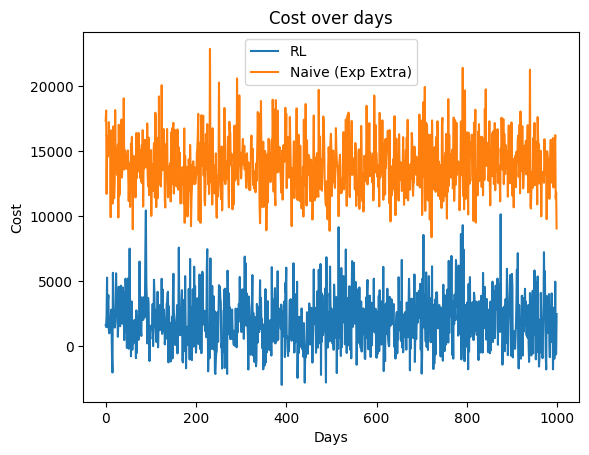

In [17]:
import torch
from policy import PolicyNetwork

def load_policy_network_checkpoint(filename):
    checkpoint = torch.load("checkpoints/" + filename + '.pth')
    policy_network = PolicyNetwork(STATE_SIZE, ACTION_SIZE)
    policy_network.mean_net.load_state_dict(checkpoint['mean_net'])
    policy_network.logstd = checkpoint['logstd']
    return policy_network


# Validation
from utils import get_ema
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
import pyperclip

policy_network = load_policy_network_checkpoint("pn_epochs1000_trajruns_10_ema100")
start = 5723031
size = 1000
day, ticks = getTicksForDay(start)
_, yest_ticks = getTicksForDay(start - 1)

costs = []
naive_store_fw = []
naive_export_extra = []

total = 0
for i in range(start + 1, start + size + 1):
    day, new_ticks = getTicksForDay(i)
    start_time = time.time()
    r = predict(day, new_ticks, yest_ticks)
    end_time = time.time()

    total += end_time - start_time
    costs.append(r["cost"])
    naive_store_fw.append(simulate_day_naive(day, new_ticks, use_flywheel=True))
    naive_export_extra.append(simulate_day_naive(day, new_ticks, export_extra=True))
    yest_ticks = ticks

    if i % 250 == 0:
        print(f"Iteration {i}")
        print("Cost:", round(r["cost"], 3))
        emas = get_ema(costs, 100)
        print("EMA Cost:", round(emas[-1], 3))
        print('-' * 20)

print("Average time taken: ", total / (size * 60))

table_md = "| Algorithm | Average Cost (per day) |\n"
table_md += "|-----------|------------------------|\n"
table_md += f"| RL | {round(np.mean(costs), 2)} |\n"
table_md += f"| Naive FW | {round(np.mean(naive_store_fw), 2)} |\n"
table_md += f"| Naive EE | {round(np.mean(naive_export_extra), 2)} |\n"
pyperclip.copy(table_md)
print("Table copied to clipboard")
display(Markdown(table_md))

# plt.plot(get_ema(costs, 100), label="RL")
plt.plot(costs, label="RL")
# plt.plot(get_ema(naive_store_fw, 100), label="Naive (With FW)")
# plt.plot(get_ema(naive_export_extra, 100), label="Naive (Exp Extra)")
plt.plot(naive_export_extra, label="Naive (Exp Extra)")
plt.xlabel("Days")
plt.ylabel("Cost")
plt.title("Cost over days")
plt.legend()
plt.show()



In [ ]:
'''Potential Improvements:

Incentivize energy efficiency by rewarding the system for maintaining a balance between energy produced, stored, and consumed.
efficiency_reward = -abs(total_energy)  # Penalize large deviations in total energy balance
reward = -(cost + total_penalty) + efficiency_reward

Stability (Flywheel)
optimal_flywheel_amt = some_value
stability_reward = -abs(day_state["flywheel_amt"] - optimal_flywheel_amt)  # Penalize deviations from the optimal level
reward = -(cost + total_penalty) + stability_reward

'''

In [ ]:
# def exponential_moving_average(data, alpha):
#     ema = [data[0]]  # Start with the first value
#     for i in range(1, len(data)):
#         ema.append(alpha * data[i] + (1 - alpha) * ema[-1])
#     return ema


# N = 20  # Number of periods for EMA
# alpha = 2 / (N + 1)
# averaged_costs = exponential_moving_average(total_costs, alpha)
# plt.plot(averaged_costs)
# plt.xlabel('Day')
# plt.ylabel('EMA Loss')
# plt.title('Exponential Moving Average Loss Over Time')
# plt.show()

# # print(costs)
# # decrease = abs(naive_costs - costs) * 100 / naive_costs
# # print("Naive: ", round(naive_costs, 2), "\tRL: ", round(costs, 2), "\tpercentage decrease: ", decrease)

In [ ]:

# def state_to_total_energy(action, tick, day_state, print_info=False):
#     power = (tick.sun / 100) * MPP 
#     sun_energy = power * TICK_LENGTH # sun in percentage to joules per tick
    
#     energy = sun_energy

#     buy_sell_amount = action[0].item()
#     energy += buy_sell_amount

#     # Add flywheel release / store to total energy and update flywheel amount
#     store_release_amount = action[1].item()

#     penalty = 0
#     if store_release_amount > 0 and store_release_amount > MAX_FLYWHEEL_CAPACITY - day_state["flywheel_amt"]:
#         penalty += (store_release_amount + day_state["flywheel_amt"]  - MAX_FLYWHEEL_CAPACITY) * EXCEED_FLYWHEEL_PENALTY
#         store_release_amount = day_state["flywheel_amt"]

#     if store_release_amount < -MAX_FLYWHEEL_CAPACITY:
#         store_release_amount = -MAX_FLYWHEEL_CAPACITY
    
#     day_state["flywheel_amt"] += store_release_amount
#     energy += store_release_amount

#     if energy < 0:
#         buy_sell_amount += -energy
#         energy = 0
    
#     if print_info:
#         print("Sun energy: ", round(sun_energy, 3))
#         print("Flywheel Amount: ", round(day_state["flywheel_amt"], 3))
#         print("Release/Store: ", round(store_release_amount, 3))
#         print("Buy/Sell: ", round(buy_sell_amount, 3))
#         print("Total Energy: ", round(energy, 3))

#     return energy, buy_sell_amount, store_release_amount, penalty

# def environment_step(action, tick, day_state, print_info=False):

#     # Update flywheel amount
#     total_energy, buy_sell_amount, store_release_amount, penalty = state_to_total_energy(action, tick, day_state, print_info=print_info)

#     # Spend energy on inst demand 
#     total_energy_spent = tick.demand # demand in joules

#     if print_info:
#         print("Inst demand:", round(tick.demand, 3))
#         print("DD before:", [round(d.energy, 3) for d in day_state["deferables"]])
    
#     # Update deferable_demands
#     deferables = day_state["deferables"]
#     allocation = []

#     for i in range(len(deferables)):

#         if deferables[i].start > tick.tick:
#             continue

#         energy_demand = deferables[i].energy
#         energy_allocated = max(0, action[i + 2].item())
#         allocation.append(energy_allocated)
#         deferables[i].energy = max(0, energy_demand - energy_allocated) # Update deferable energy
#         total_energy_spent += energy_allocated # Update total energy spent
        
#         # Spend energy to finish deferable demand if deadline is reached
#         if deferables[i].end == tick.tick and deferables[i].energy != 0:
#             total_energy_spent += deferables[i].energy
#             deferables[i].energy = 0
    
    
    
#     # Buy energy if total energy spent is greater than total energy
#     if total_energy_spent > total_energy:
#         buy_sell_amount += total_energy_spent - total_energy
    
#     # Store excess energy in flywheel
#     if total_energy < total_energy_spent:
#         day_state["flywheel_amt"] = max(MAX_FLYWHEEL_CAPACITY, day_state["flywheel_amt"] + total_energy - total_energy_spent)
    
#     cost = buy_sell_amount * tick.buy_price if buy_sell_amount > 0 else buy_sell_amount * tick.sell_price

#     if print_info:
#         print("DD after: ", [round(d.energy, 3) for d in day_state["deferables"]])
#         print("Allocation:", [round(a, 3) for a in allocation])
#         print("TE spent:", round(total_energy_spent, 3))
#         print("Buy/Sell final:", round(buy_sell_amount, 3))
#         print("Cost: ", round(cost, 2))
#         print("Penalty: ", penalty)
#         print('-'*10)
#         print()

#     return cost, penalty